# Implementing DCA in pytorch

Source CC function in [seqmodel](https://github.com/sokrypton/seqmodels/blob/master/seqmodels.ipynb)
Reimplemeting tensorflow code in pytorch. We will try to stick with the same variables as seqmodels.

In [1]:
import torch
import dca
import read_config

In [2]:
config = read_config.Config("../config_dca.yaml")

In [3]:
msa, msa_weights = dca.load_full_msa_with_weights(msa_path=config.aligned_msa_fullpath,
                                                 weights_path=config.weights_fullpath)

Reading Weights from ../working/cmx_aligned_blank_90_weights.npy
Data.shape = torch.Size([14441, 559, 21])
Weights.shape = torch.Size([14441])


In [4]:
num_epochs = config.epochs
num_epochs = 10
ret = dca.train_dca_model(device=config.device, 
                   msa=msa, msa_weights=msa_weights,
                   learning_rate = config.learning_rate,
                   num_epochs=num_epochs)

Epoch: 00 Loss=955.81
Epoch: 01 Loss=810.84
Epoch: 02 Loss=722.46
Epoch: 03 Loss=664.53
Epoch: 04 Loss=623.22
Epoch: 05 Loss=591.57
Epoch: 06 Loss=565.99
Epoch: 07 Loss=544.67
Epoch: 08 Loss=526.44
Epoch: 09 Loss=510.56


In [5]:
losses = ret['losses']
optimi

NameError: name 'optimizer' is not defined

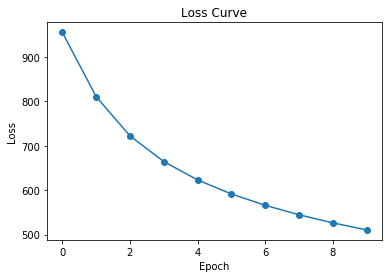

In [6]:
import matplotlib.pyplot as plt
plt.plot(losses, "o-")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
bbox = dict(boxstyle="round", fc="0.8")
plt.annotate(str(optimizer), (0.5, 0.5), xycoords='axes fraction',
            bbox=bbox);